<a href="https://colab.research.google.com/github/Geoffysicist/skewt/blob/main/f160.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pybufrkit
!pip install -q metpy

     |████████████████████████████████| 6.6 MB 4.6 MB/s 
     |████████████████████████████████| 361 kB 5.1 MB/s 
     |████████████████████████████████| 6.3 MB 40.7 MB/s 
     |████████████████████████████████| 209 kB 59.5 MB/s 


In [2]:
from ipywidgets import FileUpload
from IPython.display import display
upload = FileUpload(accept='.bfr', multiple=True)
display(upload)

FileUpload(value={}, accept='.bfr', description='Upload', multiple=True)

In [3]:
# Decode a BUFR file
from pybufrkit.decoder import Decoder
from pybufrkit.dataquery import NodePathParser, DataQuerent
# decoder = Decoder()
# with open('/content/soundings/bufr309052_all_20211209_0005_8.bfr', 'rb') as in_bufr:
#     bufr_message = Decoder().process(in_bufr.read())

for uploaded_filename in upload.value:
    data_stream = upload.value[uploaded_filename]['content'] 
bufr_message = Decoder().process(data_stream)

# bufr_message

In [4]:
# Query the data
# from pybufrkit.dataquery import NodePathParser, DataQuerent
pressures = DataQuerent(NodePathParser()).query(bufr_message, '303054/007004')
temperatures = DataQuerent(NodePathParser()).query(bufr_message, '303054/012101')
dewpoints = DataQuerent(NodePathParser()).query(bufr_message, '303054/012103')
wind_dir = DataQuerent(NodePathParser()).query(bufr_message, '303054/011001')
wind_speed = DataQuerent(NodePathParser()).query(bufr_message, '303054/011002')
geo_pot_height = DataQuerent(NodePathParser()).query(bufr_message, '303054/010009')

all_data = {
  'Pressure': pressures, 
  'Temperature': temperatures, 
  'Dewpoint': dewpoints, 
  'Wind Dir': wind_dir, 
  'Wind Speed': wind_speed, 
  'GPH': geo_pot_height
  }

In [5]:
# check all lists are the same size and change to lists
from pybufrkit.renderer import FlatJsonRenderer
for key, data in all_data.items():
  d = FlatJsonRenderer().render(data)
  print(f'{key}: {len(d[0])}')
  all_data[key] = d[0]


Pressure: 3461
Temperature: 3461
Dewpoint: 3461
Wind Dir: 3461
Wind Speed: 3461
GPH: 3461


In [6]:
# clean all the data for missing values
for key, data in all_data.items():
  for i, val in enumerate(data):
    if val is None:
      for k, d in all_data.items():
        d.pop(i)
        print(f'{k}: {len(d)}')

Pressure: 3460
Temperature: 3460
Dewpoint: 3460
Wind Dir: 3460
Wind Speed: 3460
GPH: 3460


In [10]:
# Check that pressure decreases monotonically, if not clean it
# repeat until ctr = 0
last_val = 0

ctr = 0
for i, val in enumerate(all_data['Pressure']):
  if last_val:
    if val >= last_val:
      for d in all_data.values():
        d.pop(i)
      # print(f'{i}: {val} >= {i-1}: {last_val}')
      ctr += 1
  last_val = val
print(f'{ctr} records removed')


0 records removed


In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units

In [12]:
p = all_data['Pressure']*units.Pa
T = all_data['Temperature']*units.kelvin
Td = all_data['Dewpoint']*units.kelvin
wind_speed = all_data['Wind Speed']*units('m/s')
wind_dir  = all_data['Wind Dir']*units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)


In [13]:
# Calculate the LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

# print(lcl_pressure, lcl_temperature)

# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

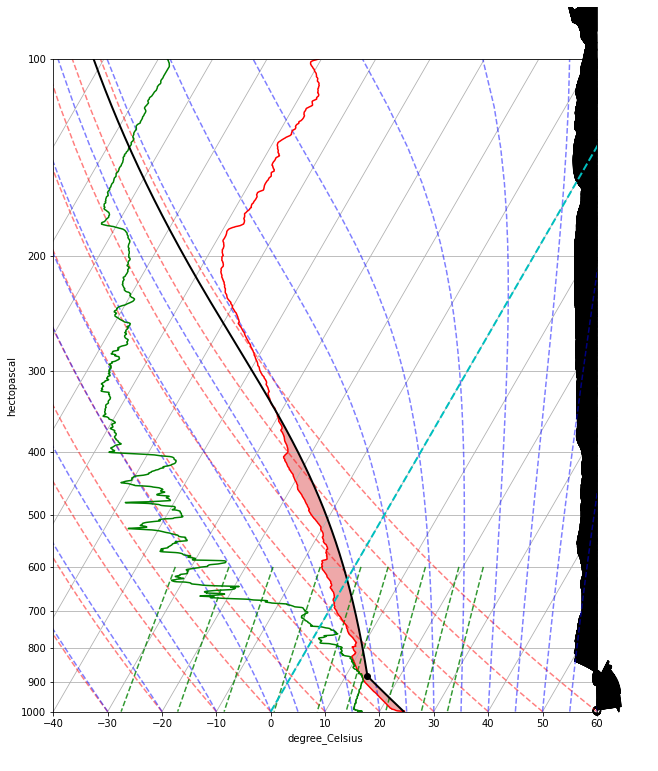

In [14]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(12, 12))
skew = SkewT(fig, rotation=30, aspect=120)


# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof, Td)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.show()